In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
df_admit = pd.read_csv('../data/admission.csv')
df_acad = pd.read_csv('../data/academic_records.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
# Kiểm tra số lượng bản ghi bị trùng lặp
print(df_acad.duplicated().sum())

24


In [4]:
# Kiểm tra số sinh viên trong tập train
len(df_acad['MA_SO_SV'].unique())

20381

In [5]:
# Kiểm tra missing value
df_acad.isna().sum()

MA_SO_SV        0
HOC_KY          0
CPA             0
GPA             0
TC_DANGKY       0
TC_HOANTHANH    0
dtype: int64

In [6]:
df_admit.isna().sum()

MA_SO_SV           0
NAM_TUYENSINH      0
PTXT               0
TOHOP_XT           0
DIEM_TRUNGTUYEN    0
DIEM_CHUAN         0
dtype: int64

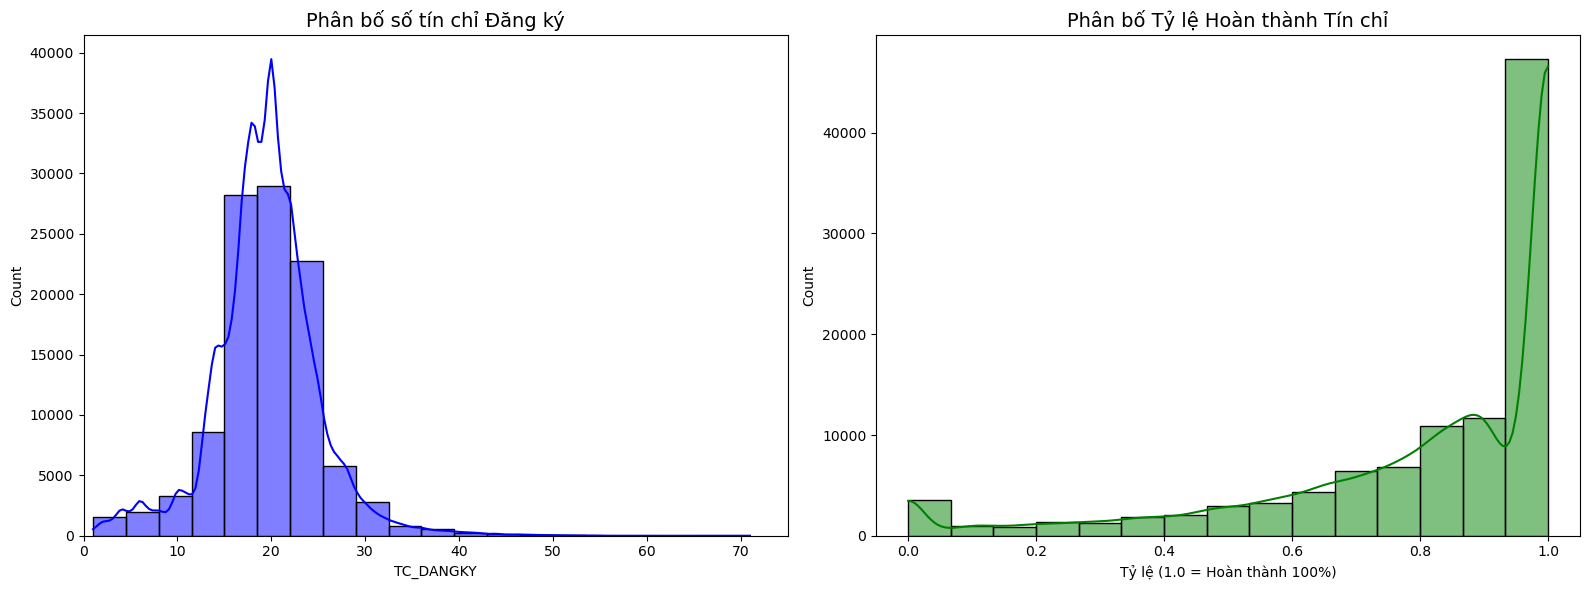

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plot_data = df_acad.copy()
plot_data['TY_LE_HOAN_THANH'] = (plot_data['TC_HOANTHANH'] / plot_data['TC_DANGKY'])

plot_data['TY_LE_HOAN_THANH'] = plot_data['TY_LE_HOAN_THANH'].replace([np.inf, -np.inf], 0).fillna(0)
plot_data['TY_LE_HOAN_THANH'] = plot_data['TY_LE_HOAN_THANH'].clip(0, 1.05) # Clip nhẹ để gom nhóm


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- BIỂU ĐỒ 1: PHÂN BỐ SỐ TÍN CHỈ ĐĂNG KÝ (MÀU XANH DƯƠNG) ---
sns.histplot(
    data=plot_data, 
    x='TC_DANGKY',
    kde=True,        
    ax=axes[0],
    color='blue',
    bins=20,
    edgecolor='black',
    alpha=0.5
)
axes[0].set_title('Phân bố số tín chỉ Đăng ký', fontsize=14)
axes[0].set_xlabel('TC_DANGKY')
axes[0].set_ylabel('Count')
axes[0].set_xlim(0, 75)

# --- BIỂU ĐỒ 2: PHÂN BỐ TỶ LỆ HOÀN THÀNH (MÀU XANH LÁ) ---
sns.histplot(
    data=plot_data, 
    x='TY_LE_HOAN_THANH', 
    kde=True, 
    ax=axes[1], 
    color='green',
    bins=15, 
    edgecolor='black',
    alpha=0.5
)
axes[1].set_title('Phân bố Tỷ lệ Hoàn thành Tín chỉ', fontsize=14)
axes[1].set_xlabel('Tỷ lệ (1.0 = Hoàn thành 100%)')
axes[1].set_ylabel('Count')
axes[1].set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [8]:
stats = df_acad['TC_DANGKY'].quantile([0.25, 0.50, 0.75, 0.95])

bang_thong_ke = pd.DataFrame({
    'Mốc Phân vị (Percentile)': [
        '25% (Q1)', 
        '50% (Median - Trung bình)', 
        '75% (Q3)', 
        '95% (Ngưỡng cao)'
    ],
    'Số Tín chỉ': stats.values
})

print("2. Phân tích tín chỉ Đăng ký" + '\n')
display(bang_thong_ke)

2. Phân tích tín chỉ Đăng ký



,Mốc Phân vị (Percentile),Số Tín chỉ
0,25% (Q1),17.0
1,50% (Median - Trung bình),20.0
2,75% (Q3),22.0
3,95% (Ngưỡng cao),28.0


In [9]:
df_acad['MA_SO_SV'] = df_acad['MA_SO_SV'].astype(str).str.strip().str.upper()
semester_counts = df_acad.groupby('MA_SO_SV').size()

# Lọc lấy những người có đúng 9 dòng (9 bản ghi)
students_9_semesters = semester_counts[semester_counts == 9]

print(f"Số sinh viên có đúng 9 dòng dữ liệu: {len(students_9_semesters)}")
print(f"Tỷ lệ: {(len(students_9_semesters) / len(semester_counts) * 100):.2f}%")

Số sinh viên có đúng 9 dòng dữ liệu: 85
Tỷ lệ: 0.42%


In [10]:
df_test['MA_SO_SV'] = df_test['MA_SO_SV'].astype(str).str.strip().str.upper()
df_admit['MA_SO_SV'] = df_admit['MA_SO_SV'].astype(str).str.strip().str.upper()

train_ids = set(df_acad['MA_SO_SV'].unique())
test_ids = set(df_test['MA_SO_SV'].unique())

# Tân sinh viên = Có trong Test nhưng KHÔNG có trong Academic
new_students_test = test_ids - train_ids
old_students_test = test_ids.intersection(train_ids)
print("PHÂN TÍCH TẬP Test")
print(f"Tổng số sinh viên trong tập Test: {len(test_ids)}")
print(f"Số lượng Tân sinh viên (Chưa có lịch sử): {len(new_students_test)}")
print(f"Số lượng Sinh viên cũ (Đã có lịch sử):    {len(old_students_test)}")
print(f"Tỷ lệ Tân sinh viên: {(len(new_students_test)/len(test_ids)*100):.2f}%")

df_acad_full = df_acad.merge(df_admit[['MA_SO_SV', 'NAM_TUYENSINH']], on='MA_SO_SV', how='left')

def parse_info(s):
    try:
        parts = str(s).strip().split()
        hk_num = int(''.join(filter(str.isdigit, parts[0])))
        year_start = int(parts[1].split('-')[0])
        return hk_num, year_start
    except:
        return np.nan, np.nan

temp = df_acad_full['HOC_KY'].apply(parse_info)
df_acad_full['HK_NUM'] = [x[0] for x in temp]
df_acad_full['NAM_HOC'] = [x[1] for x in temp]

# Logic Tân sinh viên: Năm học == Năm tuyển sinh VÀ Học kỳ == 1
mask_freshman = (
    (df_acad_full['NAM_HOC'] == df_acad_full['NAM_TUYENSINH']) & 
    (df_acad_full['HK_NUM'] == 1)
)

freshman_records = df_acad_full[mask_freshman]

print("PHÂN TÍCH TẬP ACADEMIC")
print(f"Tổng số sinh viên duy nhất: {df_acad['MA_SO_SV'].nunique()}")
print(f"Số dòng dữ liệu là 'Tân sinh viên' (HK1 Năm 1): {len(freshman_records)}")

PHÂN TÍCH TẬP Test
Tổng số sinh viên trong tập Test: 16502
Số lượng Tân sinh viên (Chưa có lịch sử): 4328
Số lượng Sinh viên cũ (Đã có lịch sử):    12174
Tỷ lệ Tân sinh viên: 26.23%
PHÂN TÍCH TẬP ACADEMIC
Tổng số sinh viên duy nhất: 20381
Số dòng dữ liệu là 'Tân sinh viên' (HK1 Năm 1): 14338


In [11]:
# Kiểm tra số lượng sinh viên có GPA != GPA tại kỳ học đầu tiên năm nhất
len(freshman_records[freshman_records['CPA'] != freshman_records['GPA']])

6749

In [12]:
df_acad_full['RATE'] = df_acad_full['TC_HOANTHANH'] / df_acad_full['TC_DANGKY']
df_acad_full['RATE'] = df_acad_full['RATE'].fillna(0)
df_acad_full['TIME_INDEX'] = df_acad_full['NAM_HOC'] * 10 + df_acad_full['HK_NUM']
thong_ke_hk = df_acad_full.groupby(['TIME_INDEX', 'HOC_KY']).agg({
    'GPA': 'mean',
    'RATE': 'mean',
    'MA_SO_SV': 'count'
}).reset_index()


thong_ke_hk = thong_ke_hk.rename(columns={
    'HOC_KY': 'Học kỳ',
    'GPA': 'GPA TB',
    'MA_SO_SV': 'Số bản ghi'
})

thong_ke_hk['GPA TB'] = thong_ke_hk['GPA TB'].round(2)

thong_ke_hk['Tỷ lệ Hoàn thành'] = (thong_ke_hk['RATE'] * 100).round(1).astype(str) + '%'

final_table = thong_ke_hk[['Học kỳ', 'GPA TB', 'Tỷ lệ Hoàn thành', 'Số bản ghi']].sort_values(by='Học kỳ') 
final_table = thong_ke_hk.sort_values('TIME_INDEX')[['Học kỳ', 'GPA TB', 'Tỷ lệ Hoàn thành', 'Số bản ghi']]

print("Đào sâu: Hiệu suất học tập theo Học kỳ")
display(final_table)

Đào sâu: Hiệu suất học tập theo Học kỳ


,Học kỳ,GPA TB,Tỷ lệ Hoàn thành,Số bản ghi
0,HK1 2020-2021,2.12,75.7%,9186
1,HK2 2020-2021,2.23,81.7%,9175
2,HK1 2021-2022,2.39,88.0%,12698
3,HK2 2021-2022,2.32,79.6%,12434
4,HK1 2022-2023,2.32,80.3%,15486
5,HK2 2022-2023,2.30,79.2%,14504
6,HK1 2023-2024,2.30,80.7%,17099
7,HK2 2023-2024,2.29,77.4%,15144
